In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
import seaborn as sns
import numpy as np
import math
from scipy import stats
from astropy.stats import RipleysKEstimator
from msresist.distances import PlotSingleDistances, PlotClosestN, PlotNhrsdistances, Plot_Logmean, PlotRipleysK, BarPlotRipleysK, PlotRipleysK_TimeCourse, BarPlotRipleysK_TimePlots, DataFrameRipleysK

sns.set(style="whitegrid", font_scale=1.1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [2]:
mutants = ['PC9', 'KO', 'KIN', 'KD', 'M4', 'M5', 'M7', 'M10', 'M11', 'M15']
lines = ["WT", "KO", "KI", "KD", "Y634F", "Y643F", "Y698F", "Y726F", "Y750F ", "Y821F"]
lines_num = ["WT", "KO", "KI", "KD", "634", "643", "698", "726", "750", "821"]

<Figure size 576x360 with 0 Axes>

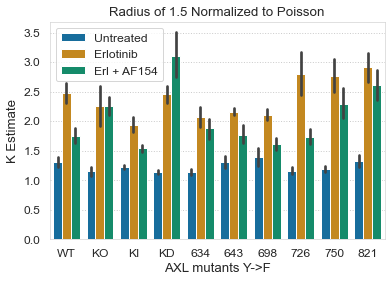

<Figure size 576x360 with 0 Axes>

In [3]:
treatments = ['ut', 'e', 'ae']
legendlabels = ["Untreated", "Erlotinib", "Erl + AF154"]

replicates = 6
radius = np.linspace(1.5, 14.67, 1)
folder = '48hrs'
BarPlotRipleysK(folder, mutants, lines_num, treatments, legendlabels, replicates, radius)
plt.figure(figsize=(8, 5))
# plt.savefig("ClusterEffect.svg", bbox_inches='tight', format='svg', dpi=1200)

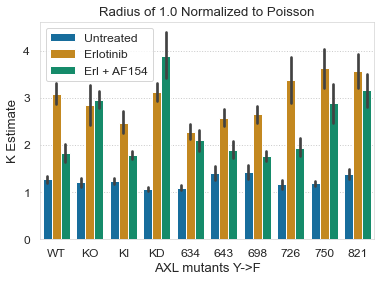

In [4]:
radius = np.linspace(1, 14.67, 1)
BarPlotRipleysK(folder, mutants, lines_num, treatments, legendlabels, replicates, radius)
plt.legend(loc=2)
plt.savefig("ClusterEffect.svg", bbox_inches='tight', format='svg', dpi=1200)

In [5]:
df = DataFrameRipleysK(folder, mutants, treatments, replicates, radius)
df.head()

K Estimate
Mutant Treatment            
KD     ae           3.900568
       e            3.130709
       ut           1.069389
KIN    ae           1.794788
       e            2.472251

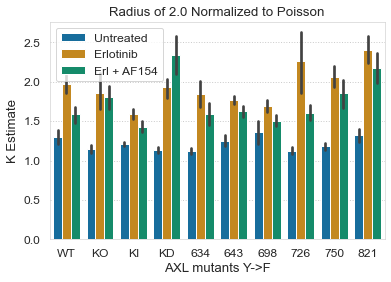

In [6]:
radius = np.linspace(2, 14.67, 1)
BarPlotRipleysK(folder, mutants, lines_num, treatments, legendlabels, replicates, radius)

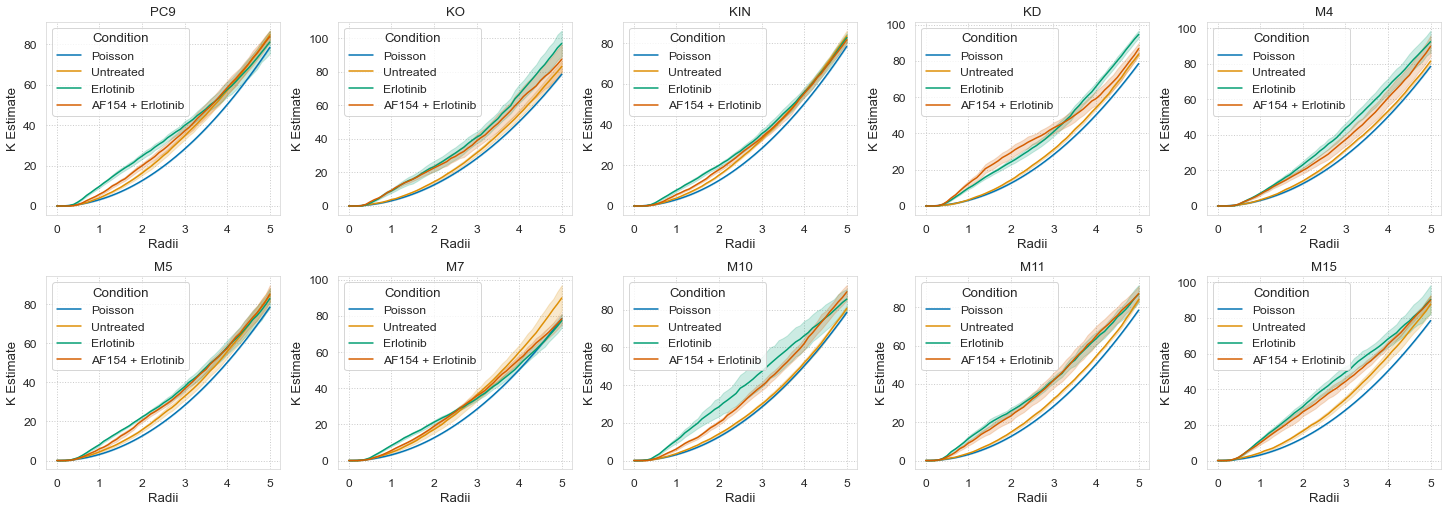

In [7]:
mutants = ['PC9', 'KO', 'KIN', 'KD', 'M4', 'M5', 'M7', 'M10', 'M11', 'M15']
treatments = ['ut', 'e', 'ae']
replicates = 6
fig, axs = plt.subplots(nrows=2, ncols=5, figsize = (20, 7), constrained_layout=True)
for i in range(10):
    PlotRipleysK(folder, mutants[i], treatments, replicates, ax=axs[i // 5][i % 5])
# plt.savefig("ClusterEffect.svg", bbox_inches='tight', format='svg', dpi=1200)

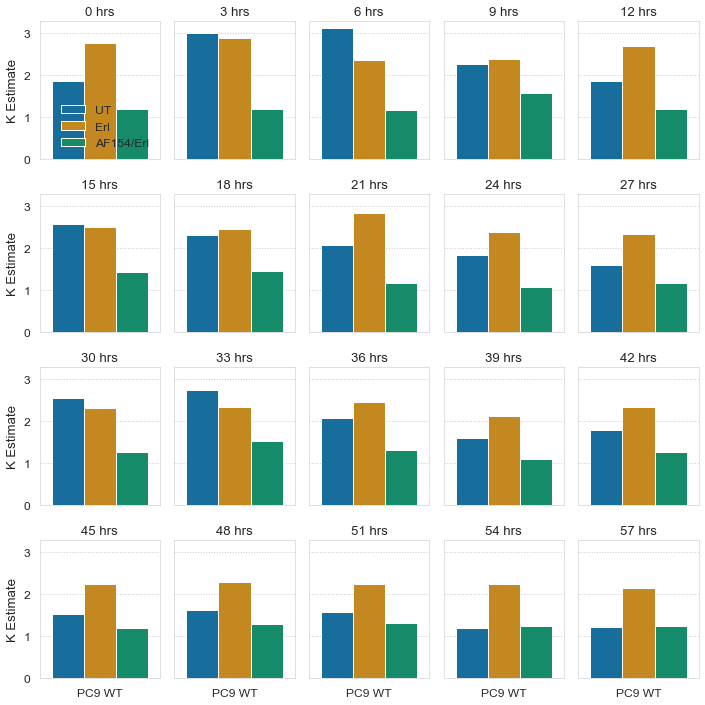

In [8]:
folder = 'PC9_TimeCourse'
extensions = ['C1', 'F1', 'D1']
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(10, 10), sharex=True, sharey=True)
radius = np.linspace(1.5, 14.67, 1)
treatments = ['UT', "Erl", "AF154/Erl"]
mutant = 'PC9 WT'
l = [0, 5, 10, 15]
for i in range(20):
    #PlotRipleysK_TimeCourse(folder, extensions, (i) * 3, ax[(i // 4)][(i % 4)])
    extensions = ['C1_' + str(i*3), 'F1_' + str(i*3), 'D1_' + str(i*3)]
    BarPlotRipleysK_TimePlots(folder, mutant, extensions, treatments, radius, ax[(i // 5)][(i % 5)])
    ax[(i // 5)][(i % 5)].set_xlabel("")
    ax[(i // 5)][(i % 5)].set_title(str(i*3) + ' hrs')
    ax[(i // 5)][(i % 5)].legend(loc=4, frameon=False)
    if i != 0:
        ax[(i // 5)][(i % 5)].get_legend().remove()
    if i not in l:
        ax[(i // 5)][(i % 5)].set_ylabel("")

plt.tight_layout()
# plt.savefig("ClusterEffect.svg", bbox_inches='tight', format='svg', dpi=1200)

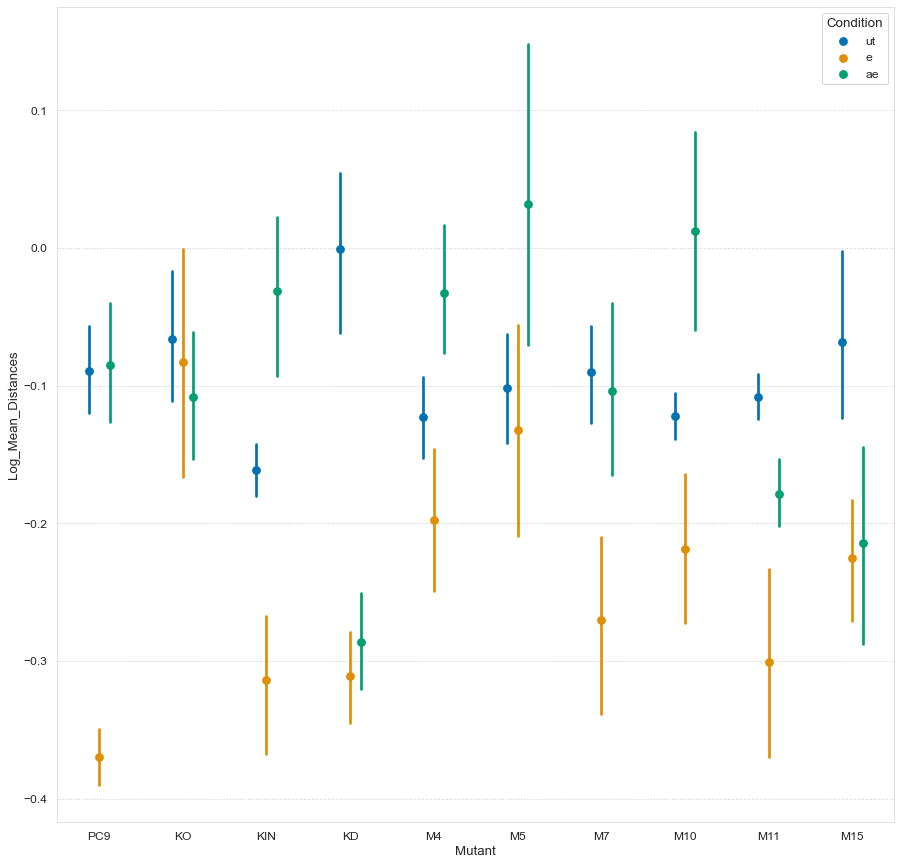

In [9]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (15, 15))
mutants = ['PC9', 'KO', 'KIN', 'KD', 'M4', 'M5', 'M7', 'M10', 'M11', 'M15']
treatments = ['ut', 'e', 'ae']
replicates = 6
Plot_Logmean('48hrs', mutants, treatments, replicates, ax, vs_count=False, cells=(2, 2))

#fig.savefig("Mutants48hrs_logmean_average")

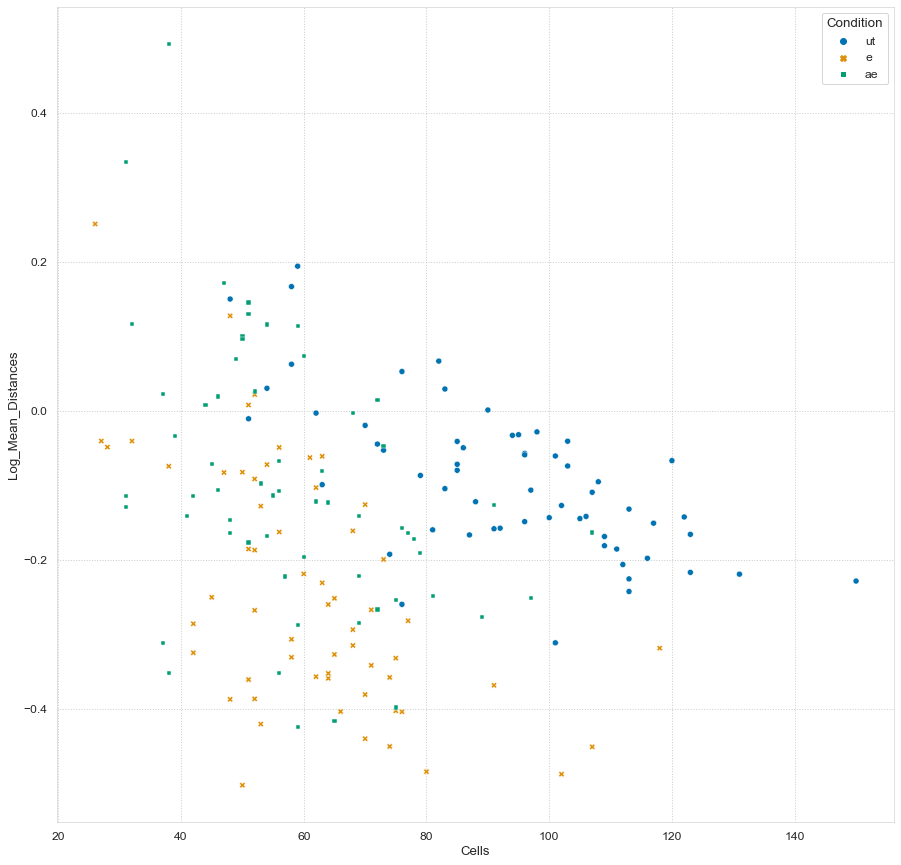

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (15, 15))
mutants = ['PC9', 'KO', 'KIN', 'KD', 'M4', 'M5', 'M7', 'M10', 'M11', 'M15']
treatments = ['ut', 'e', 'ae']
replicates = 6
Plot_Logmean('48hrs', mutants, treatments, replicates, ax, vs_count=True, cells=(2, 2))

#fig.savefig("Mutants48hrs_logmean_average")

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (20, 14))
mutants = ['PC9', 'KO', 'KIN', 'KD', 'M4', 'M5', 'M7', 'M10', 'M11', 'M15']
treatments = ['ut', 'e', 'ae']
replicates = 6
PlotNhrsdistances('48hrs', mutants, treatments, replicates, ax, log=True, logmean=False, cells=(2, 2))


In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 14))
PlotSingleDistances('PC9_UT', 'ut', ax[0, 0])
PlotSingleDistances('PC9_E', 'e', ax[0, 1])
PlotSingleDistances('PC9_UT', 'ut', ax[1, 0], True)
PlotSingleDistances('PC9_E', 'e', ax[1, 1], True)


In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 14))
PlotClosestN('PC9_TimeCourse', 'C1', ax[0,0])
PlotClosestN('PC9_TimeCourse', 'F1', ax[0,1])
PlotClosestN('PC9_TimeCourse', 'C1', ax[1,0], True)
PlotClosestN('PC9_TimeCourse', 'F1', ax[1,1], True)


In [5]:
'''def ConfidenceKest(radii):
    coords = []
    for i in range(100):
        x = np.random.uniform(low=0, high=14.67, size=(100,1))
        y = np.random.uniform(low=0, high=10.83, size=(100,1))
        both = np.hstack((x,y))
        coords.append(both)
    
    Kest = RipleysKEstimator(area=158.8761, x_max=14.67, y_max=10.83, x_min=0, y_min=0)
    Kests = []
    for coord in coords:
        Kests.append(Kest(data=coord, radii=radii, mode='ripley'))
    MaxKest = np.zeros(radii.size)
    MinKest = np.zeros(radii.size)
    for i in range(radii.size):
        max_val = 0
        min_val = np.inf
        for kest in Kests:
            if kest[i] > max_val:
                max_val = kest[i]
            if kest[i] < min_val:
                min_val = kest[i]
        MaxKest[i] = max_val
        MinKest[i] = min_val
    return MaxKest, MinKest'''


"def ConfidenceKest(radii):\n    coords = []\n    for i in range(100):\n        x = np.random.uniform(low=0, high=14.67, size=(100,1))\n        y = np.random.uniform(low=0, high=10.83, size=(100,1))\n        both = np.hstack((x,y))\n        coords.append(both)\n    \n    Kest = RipleysKEstimator(area=158.8761, x_max=14.67, y_max=10.83, x_min=0, y_min=0)\n    Kests = []\n    for coord in coords:\n        Kests.append(Kest(data=coord, radii=radii, mode='ripley'))\n    MaxKest = np.zeros(radii.size)\n    MinKest = np.zeros(radii.size)\n    for i in range(radii.size):\n        max_val = 0\n        min_val = np.inf\n        for kest in Kests:\n            if kest[i] > max_val:\n                max_val = kest[i]\n            if kest[i] < min_val:\n                min_val = kest[i]\n        MaxKest[i] = max_val\n        MinKest[i] = min_val\n    return MaxKest, MinKest"